<a href="https://colab.research.google.com/github/cesaradrianpenalozaalarcon-byte/Simulacion-2/blob/main/Simulacion_discreta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚗⚡ SIMULACIÓN DE ESTACIÓN DE CARGA ELÉCTRICA ⚡🚗
Estaciones: 4 | Tiempo de simulación: 100
[   0.0] 🚗 Coche-000 llega | En cola: 0
[   0.0] ⚡ Coche-000 carga  | Esperó: 0.0
[   2.9] 🚗 Coche-001 llega | En cola: 0
[   2.9] ⚡ Coche-001 carga  | Esperó: 0.0
[   3.1] 🚗 Coche-002 llega | En cola: 0
[   3.1] ⚡ Coche-002 carga  | Esperó: 0.0
[   5.1] 🚗 Coche-003 llega | En cola: 0
[   5.1] ⚡ Coche-003 carga  | Esperó: 0.0
[   6.0] 🚗 Coche-004 llega | En cola: 0
[   6.5] 🚗 Coche-005 llega | En cola: 1
[   7.0] 🚗 Coche-006 llega | En cola: 2
[   7.3] 🚗 Coche-007 llega | En cola: 3
[   8.4] 🚗 Coche-008 llega | En cola: 4
[   9.7] 🚗 Coche-009 llega | En cola: 5
[  10.2] 🚗 Coche-010 llega | En cola: 6
[  10.6] ✅ Coche-000 sale  | Estuvo: 10.6
[  10.6] ⚡ Coche-004 carga  | Esperó: 4.7
[  11.2] ✅ Coche-001 sale  | Estuvo: 8.4
[  11.2] ⚡ Coche-005 carga  | Esperó: 4.7
[  11.7] 🚗 Coche-011 llega | En cola: 5
[  12.6] ✅ Coche-002 sale  | Estuvo: 9.6
[  12.6] ⚡ Coche-006 carga  | Esperó: 5.6
[  13.5] 🚗 C

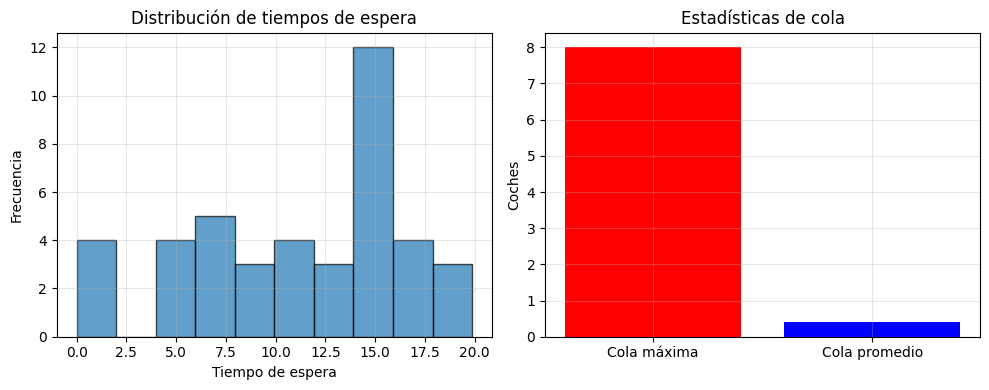

In [17]:
import simpy
import random
import statistics
from tabulate import tabulate
# Definimos una clase
#Una clase es como un arreglo de objetos similares
class EstacionDeCarga:
    #Se busca simular una estacion de carga de un coche electrico con 4 servidores
    # init guarda el entorno en simpy
    def __init__(self, env, num_estaciones):
        #
        self.env = env
        #self env sera usado para los procesos
        #Toma el parámetro env y lo guarda como atributo del objeto

        #Aqui definimos nuestra cantidad de servidores
        self.estaciones = simpy.Resource(env, capacity=num_estaciones)
        # Guardamos el numero de estaciones como atributo, para poder restar y sumar cuando se desocupen
        self.num_estaciones = num_estaciones

        #Genramos unas listas para poder graficar las estadisticas
        self.tiempos_espera = []
        self.tiempos_sistema = []
        self.coches_atendidos = 0
        self.cola_maxima = 0

    def coche(self, nombre): #Definimos la funcion
        #proceso de llegada un coche electrico
        tiempo_llegada = self.env.now #Tomamos el tiempo actual

        print(f'[{self.env.now:6.1f}]  {nombre} llega | En cola: {len(self.estaciones.queue)}')

        # Actualizar tamaño máximo de cola
        self.cola_maxima = max(self.cola_maxima, len(self.estaciones.queue))

        # Solicitar estación
        with self.estaciones.request() as solicitud:
            # Esperar en cola
            yield solicitud

            # Calcular tiempo de espera
            tiempo_espera = self.env.now - tiempo_llegada
            self.tiempos_espera.append(tiempo_espera)

            print(f'[{self.env.now:6.1f}]  {nombre} carga  | Esperó: {tiempo_espera:.1f}')

            # Tiempo de carga (aleatorio)
            tiempo_carga = random.uniform(8, 12)
            yield self.env.timeout(tiempo_carga)

            # Calcular tiempo total en sistema
            tiempo_sistema = self.env.now - tiempo_llegada
            self.tiempos_sistema.append(tiempo_sistema)
            self.coches_atendidos += 1

            print(f'[{self.env.now:6.1f}]  {nombre} sale  | Estuvo: {tiempo_sistema:.1f}')

    def generar_coches(self):
        #Genera coches que llegan a la estación
        i = 0
        while True:
            # Intervalo entre llegadas (aleatorio)
            intervalo = random.expovariate(1.0 / 2.5)  # Llegada cada 2.5 en promedio

            # Crear nuevo coche
            self.env.process(self.coche(f'Coche-{i:03d}'))
            i = i+1

            # Esperar hasta próxima llegada
            yield self.env.timeout(intervalo)

    def mostrar_estadisticas(self):
        #Muestra estadísticas de la simulación#
        print("\n" + "="*60)
        print("📊 ESTADÍSTICAS DE LA SIMULACIÓN")
        print("="*60)

        if self.tiempos_espera:
            datos = [
                ["Estaciones disponibles", self.num_estaciones],
                ["Coches atendidos", self.coches_atendidos],
                ["Tiempo promedio de espera", f"{statistics.mean(self.tiempos_espera):.2f}"],
                ["Tiempo máximo de espera", f"{max(self.tiempos_espera):.2f}"],
                ["Tiempo mínimo de espera", f"{min(self.tiempos_espera):.2f}"],
                ["Tiempo promedio en sistema", f"{statistics.mean(self.tiempos_sistema):.2f}"],
                ["Tamaño máximo de cola", self.cola_maxima],
                ["Utilización estaciones", f"{(self.coches_atendidos * statistics.mean(self.tiempos_sistema if self.tiempos_sistema else [0]) / (self.num_estaciones * TIEMPO_SIMULACION)) * 100:.1f}%"],
            ]

            print(tabulate(datos, headers=["Métrica", "Valor"], tablefmt="grid"))
        else:
            print("No se atendieron suficientes coches para calcular estadísticas")

        print("\n HISTOGRAMA DE TIEMPOS DE ESPERA:")
        if self.tiempos_espera:
            import matplotlib.pyplot as plt

            plt.figure(figsize=(10, 4))

            # Gráfico 1: Tiempos de espera
            plt.subplot(1, 2, 1)
            plt.hist(self.tiempos_espera, bins=10, edgecolor='black', alpha=0.7)
            plt.title('Distribución de tiempos de espera')
            plt.xlabel('Tiempo de espera')
            plt.ylabel('Frecuencia')
            plt.grid(True, alpha=0.3)

            # Gráfico 2: Evolución de la cola (simplificado)
            plt.subplot(1, 2, 2)
            cola_promedio = len(self.tiempos_espera) / TIEMPO_SIMULACION if self.tiempos_espera else 0
            plt.bar(['Cola máxima', 'Cola promedio'],
                   [self.cola_maxima, cola_promedio],
                   color=['red', 'blue'])
            plt.title('Estadísticas de cola')
            plt.ylabel('Coches')
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

# Parámetros de simulación
NUM_ESTACIONES = 4
TIEMPO_SIMULACION = 100

# Ejecutar simulación
print(" Simulacion de estacion electrica")
print(f"Estaciones: {NUM_ESTACIONES} | Tiempo de simulación: {TIEMPO_SIMULACION}")
print("="*60)

env = simpy.Environment()
estacion = EstacionDeCarga(env, NUM_ESTACIONES)

# Iniciar generador de coches
env.process(estacion.generar_coches())

# Ejecutar simulación
env.run(until=TIEMPO_SIMULACION)

# Mostrar estadísticas
estacion.mostrar_estadisticas()

 Simulacion de estacion electrica
Estaciones: 4 | Tiempo de simulación: 100
[   0.0]  Coche-000 llega | En cola: 0
[   0.0]  Coche-000 carga  | Esperó: 0.0
[   1.7]  Coche-001 llega | En cola: 0
[   1.7]  Coche-001 carga  | Esperó: 0.0
[   4.7]  Coche-002 llega | En cola: 0
[   4.7]  Coche-002 carga  | Esperó: 0.0
[  10.6]  Coche-001 sale  | Estuvo: 8.9
[  11.8]  Coche-000 sale  | Estuvo: 11.8
[  13.2]  Coche-003 llega | En cola: 0
[  13.2]  Coche-003 carga  | Esperó: 0.0
[  13.4]  Coche-002 sale  | Estuvo: 8.6
[  15.7]  Coche-004 llega | En cola: 0
[  15.7]  Coche-004 carga  | Esperó: 0.0
[  16.1]  Coche-005 llega | En cola: 0
[  16.1]  Coche-005 carga  | Esperó: 0.0
[  16.3]  Coche-006 llega | En cola: 0
[  16.3]  Coche-006 carga  | Esperó: 0.0
[  17.2]  Coche-007 llega | En cola: 0
[  19.6]  Coche-008 llega | En cola: 1
[  21.9]  Coche-009 llega | En cola: 2
[  23.2]  Coche-003 sale  | Estuvo: 10.0
[  23.2]  Coche-007 carga  | Esperó: 6.0
[  24.4]  Coche-006 sale  | Estuvo: 8.1
[  2

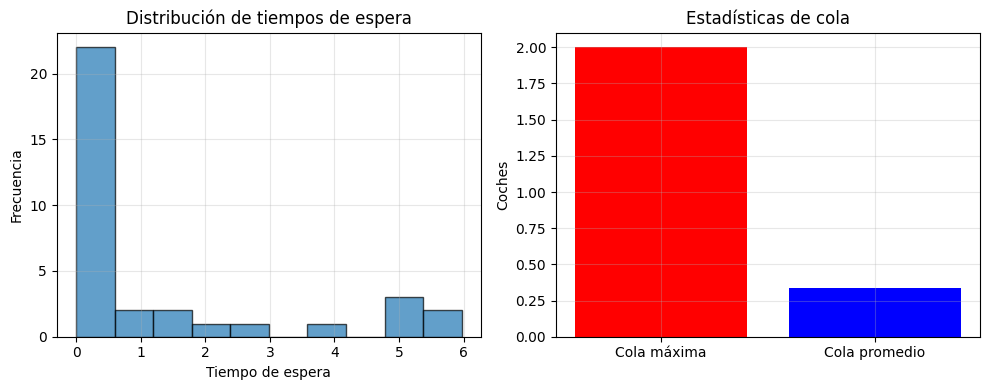

In [18]:
import simpy
import random
import statistics
from tabulate import tabulate
# Definimos una clase
#Una clase es como un arreglo de objetos similares
class EstacionDeCarga:
    #Se busca simular una estacion de carga de un coche electrico con 4 servidores
    # init guarda el entorno en simpy
    def __init__(self, env, num_estaciones):
        #
        self.env = env
        #self env sera usado para los procesos
        #Toma el parámetro env y lo guarda como atributo del objeto

        #Aqui definimos nuestra cantidad de servidores
        self.estaciones = simpy.Resource(env, capacity=num_estaciones)
        # Guardamos el numero de estaciones como atributo, para poder restar y sumar cuando se desocupen
        self.num_estaciones = num_estaciones

        #Genramos unas listas para poder graficar las estadisticas
        self.tiempos_espera = []
        self.tiempos_sistema = []
        self.coches_atendidos = 0
        self.cola_maxima = 0

    def coche(self, nombre): #Definimos la funcion
        #proceso de llegada un coche electrico
        tiempo_llegada = self.env.now #Tomamos el tiempo actual

        print(f'[{self.env.now:6.1f}]  {nombre} llega | En cola: {len(self.estaciones.queue)}')

        # Actualizar tamaño máximo de cola
        self.cola_maxima = max(self.cola_maxima, len(self.estaciones.queue))

        # Solicitar estación
        with self.estaciones.request() as solicitud:
            # Esperar en cola
            yield solicitud

            # Calcular tiempo de espera
            tiempo_espera = self.env.now - tiempo_llegada
            self.tiempos_espera.append(tiempo_espera)

            print(f'[{self.env.now:6.1f}]  {nombre} carga  | Esperó: {tiempo_espera:.1f}')

            # Tiempo de carga (aleatorio)
            tiempo_carga = random.uniform(8, 12)
            yield self.env.timeout(tiempo_carga)

            # Calcular tiempo total en sistema
            tiempo_sistema = self.env.now - tiempo_llegada
            self.tiempos_sistema.append(tiempo_sistema)
            self.coches_atendidos += 1

            print(f'[{self.env.now:6.1f}]  {nombre} sale  | Estuvo: {tiempo_sistema:.1f}')

    def generar_coches(self):
        #Genera coches que llegan a la estación
        i = 0
        while True:
            # Intervalo entre llegadas (aleatorio)
            intervalo = random.expovariate(1.0 / 2.5)  # Llegada cada 2.5 en promedio

            # Crear nuevo coche
            self.env.process(self.coche(f'Coche-{i:03d}'))
            i = i+1

            # Esperar hasta próxima llegada
            yield self.env.timeout(intervalo)

    def mostrar_estadisticas(self):
        #Muestra estadísticas de la simulación
        print("\n" + "="*60)
        print(" ESTADÍSTICAS DE LA SIMULACIÓN")
        print("="*60)

        if self.tiempos_espera:
            datos = [
                ["Estaciones disponibles", self.num_estaciones],
                ["Coches atendidos", self.coches_atendidos],
                ["Tiempo promedio de espera", f"{statistics.mean(self.tiempos_espera):.2f}"],
                ["Tiempo máximo de espera", f"{max(self.tiempos_espera):.2f}"],
                ["Tiempo promedio en sistema", f"{statistics.mean(self.tiempos_sistema):.2f}"],
                ["Tamaño máximo de cola", self.cola_maxima],
            ]

            print(tabulate(datos, headers=["Métrica", "Valor"], tablefmt="grid"))
        else:
            print("No se atendieron suficientes coches para calcular estadísticas")

        print("\n HISTOGRAMA DE TIEMPOS DE ESPERA:")
        if self.tiempos_espera:
            import matplotlib.pyplot as plt

            plt.figure(figsize=(10, 4))

            # Grafico tiempos de espera
            plt.subplot(1, 2, 1)
            plt.hist(self.tiempos_espera, bins=10, edgecolor='black', alpha=0.7)
            plt.title('Distribución de tiempos de espera')
            plt.xlabel('Tiempo de espera')
            plt.ylabel('Frecuencia')
            plt.grid(True, alpha=0.3)

            # Gráfico 2: Evolución de la cola
            plt.subplot(1, 2, 2)
            cola_promedio = len(self.tiempos_espera) / TIEMPO_SIMULACION if self.tiempos_espera else 0
            plt.bar(['Cola máxima', 'Cola promedio'],
                   [self.cola_maxima, cola_promedio],
                   color=['red', 'blue'])
            plt.title('Estadísticas de cola')
            plt.ylabel('Coches')
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

# Parámetros de simulación
NUM_ESTACIONES = 4
TIEMPO_SIMULACION = 100

# Ejecutar simulación
print(" Simulacion de estacion electrica")
print(f"Estaciones: {NUM_ESTACIONES} | Tiempo de simulación: {TIEMPO_SIMULACION}")
print("="*60)

env = simpy.Environment()
estacion = EstacionDeCarga(env, NUM_ESTACIONES)

# Iniciar generador de coches
env.process(estacion.generar_coches())

# Ejecutar simulación
env.run(until=TIEMPO_SIMULACION)

# Mostrar estadísticas
estacion.mostrar_estadisticas()